# Incumplimiento de Pagos de Clientes de Tarjetas de Crédito

  ## Ajuste de hiperparámetros

La base de datos que estás utilizando es el "Default of Credit Card Clients Dataset", y habíamos dicho que:

Contiene información de 30.000 titulares de tarjetas de crédito en Taiwán, con el objetivo de predecir si un cliente incumplirá el pago de su deuda el mes siguiente.

Este dataset es comúnmente utilizado en tareas de modelado de riesgo crediticio y problemas de clasificación binaria.

Variables: 

- ID: ID de cada cliente
- LIMIT_BAL: Importe del crédito otorgado en dólares taiwaneses (incluye crédito individual y familiar/complementario)
- SEXO: Género (1=masculino, 2=femenino)
- EDUCACIÓN: (1=posgrado, 2=universitario, 3=bachillerato, 4=otros, 5=desconocido, 6=desconocido)
- MATRIMONIO: Estado civil (1=casado, 2=soltero, 3=otros)
- EDAD: Edad en años
- PAY_0: Estado de pago en septiembre de 2005 (-1=pago al día, 1=retraso de un mes en el pago, 2=retraso de dos meses en el pago, ... 
         8=retraso de ocho meses en el pago, 9=retraso de nueve meses o más en el pago)
- PAY_2: Estado de pago en agosto de 2005 (escala igual a la anterior)
- PAY_3: Estado de pago en julio de 2005 (escala igual a la anterior)
- PAY_4: Estado de pago en junio de 2005 (escala igual a la anterior)
- PAY_5: Estado de pago en mayo de 2005 (escala igual a la anterior)
- PAY_6: Estado de pago en abril de 2005 (escala igual a la anterior)
- BILL_AMT1: Importe del extracto de la factura en septiembre de 2005 (dólares taiwaneses)
- BILL_AMT2: Importe del extracto de la factura en agosto de 2005 (dólares taiwaneses)
- BILL_AMT3: Importe del extracto de la factura en julio, 2005 (dólares taiwaneses)
- BILL_AMT4: Importe del extracto de factura de junio de 2005 (dólares taiwaneses)
- BILL_AMT5: Importe del extracto de factura de mayo de 2005 (dólares taiwaneses)
- BILL_AMT6: Importe del extracto de factura de abril de 2005 (dólares taiwaneses)
- PAY_AMT1: Importe del pago anterior de septiembre de 2005 (dólares taiwaneses)
- PAY_AMT2: Importe del pago anterior de agosto de 2005 (dólares taiwaneses)
- PAY_AMT3: Importe del pago anterior de julio de 2005 (dólares taiwaneses)
- PAY_AMT4: Importe del pago anterior de junio de 2005 (dólares taiwaneses)
- PAY_AMT5: Importe del pago anterior de mayo de 2005 (dólares taiwaneses)
- PAY_AMT6: Importe del pago anterior de abril de 2005 (dólares taiwaneses)
         default.payment.next.month: Pago por defecto (1=sí, 0=no)

In [ ]:
pip install optuna

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import warnings
import optuna
warnings.filterwarnings('ignore')

## EDA

Es importante antes de realizar algún trabajo, conocer los datos, mediante un análisis exploratio de datos.

In [14]:
# Cargamos el dataset

df = pd.read_csv("UCI_Credit_Card.csv")
df.rename(columns={'default.payment.next.month': 'default'}, inplace=True)

In [15]:
print("Tamaño del dataset:", df.shape)
display(df.head())

Tamaño del dataset: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [8]:
# Información del dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

In [12]:
# Valores faltantes

missing = df.isnull().sum()
print("Valores nulos por columna:")
print(missing[missing > 0])

Valores nulos por columna:
Series([], dtype: int64)


### Estadísticas descriptivas

In [13]:
display(df.describe())

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


El límite de crédito promedio es de 167.484 unidades, y la edad media de los clientes es de 35 años. La mayoría son mujeres, con educación universitaria y casados o solteros. Las variables de pago muestran que muchos clientes han pagado puntualmente, aunque hay casos de retrasos severos. Los montos facturados y pagos varían ampliamente, con valores extremos altos. La variable objetivo indica que el 22.1% de los clientes incurrió en default, lo que señala un desequilibrio de clases importante para el análisis predictivo.

### Distribución de la Variable objetivo

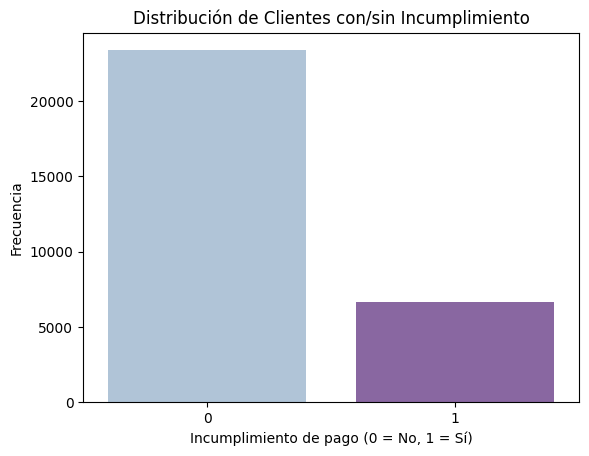

Proporción de clases:
default
0    0.7788
1    0.2212
Name: proportion, dtype: float64


In [25]:
sns.countplot(data=df, x='default', palette='BuPu')
plt.title("Distribución de Clientes con/sin Incumplimiento")
plt.xlabel("Incumplimiento de pago (0 = No, 1 = Sí)")
plt.ylabel("Frecuencia")
plt.show()

# Proporción de cada clase
print("Proporción de clases:")
print(df['default'].value_counts(normalize=True))

La gráfica muestra una clara desproporción entre los clientes que han incumplido pagos (clase 1) y los que no (clase 0). Aproximadamente el 22% de los clientes presentan incumplimiento, mientras que el 78% no lo hacen. Este desbalance de clases es relevante, ya que puede afectar el desempeño de los modelos de clasificación, especialmente en la predicción de la clase minoritaria (clientes en default). Será importante tenerlo en cuenta en el ajuste de hiperparámetros y en la evaluación del modelo.

### Histogramas

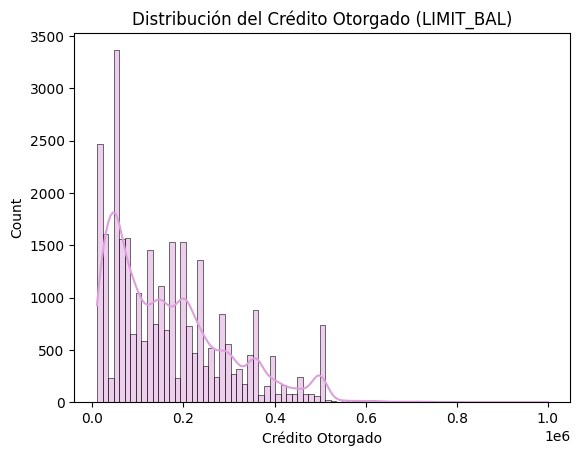

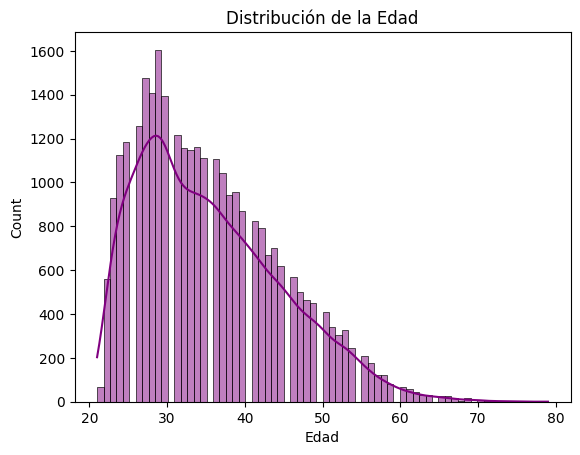

In [23]:
# Histograma de crédito otorgado
sns.histplot(df['LIMIT_BAL'], kde=True, color='plum')
plt.title('Distribución del Crédito Otorgado (LIMIT_BAL)')
plt.xlabel('Crédito Otorgado')
plt.show()

# Histograma de edad
sns.histplot(df['AGE'], kde=True, color='purple')
plt.title('Distribución de la Edad')
plt.xlabel('Edad')
plt.show()

Los histogramas muestran la distribución de dos variables clave: el crédito otorgado y la edad. En el primer gráfico, se observa que la mayoría de los clientes tiene un límite de crédito entre 50.000 y 150.000 unidades, con una fuerte concentración hacia los valores más bajos, lo que sugiere una distribución sesgada a la derecha. En cuanto a la edad, la mayoría de los clientes se encuentra entre los 25 y 40 años, con una tendencia decreciente conforme aumenta la edad. Esta información es útil para entender el perfil demográfico y financiero predominante entre los clientes del banco.

### Relación entre las variables y el impago

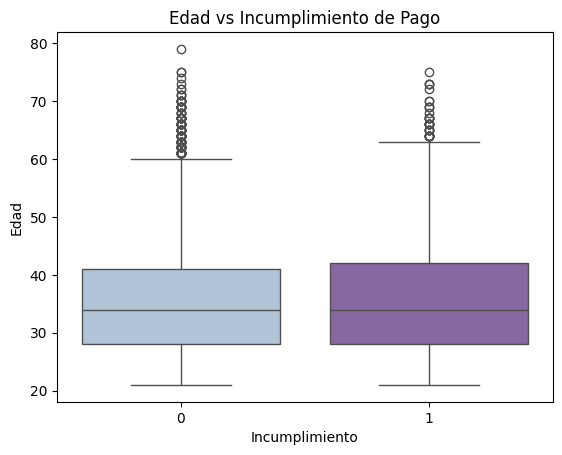

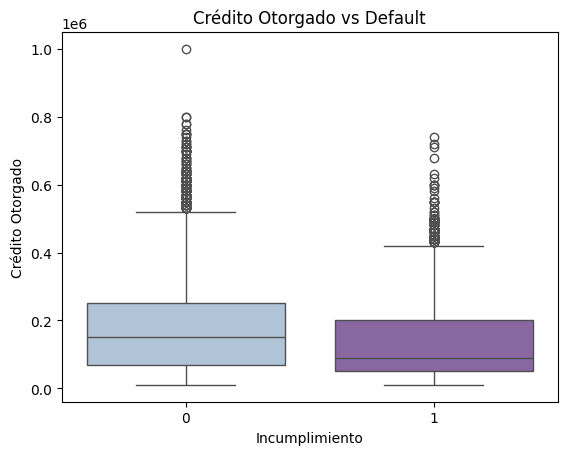

In [28]:
# Boxplot de edad vs default
sns.boxplot(x='default', y='AGE', data=df, palette='BuPu')
plt.title('Edad vs Incumplimiento de Pago')
plt.xlabel('Incumplimiento')
plt.ylabel('Edad')
plt.show()

# Boxplot de crédito vs default
sns.boxplot(x='default', y='LIMIT_BAL', data=df, palette='BuPu')
plt.title('Crédito Otorgado vs Default')
plt.xlabel('Incumplimiento')
plt.ylabel('Crédito Otorgado')
plt.show()

A partir de los gráficos obtenidos durante el análisis exploratorio, se pueden extraer algunas observaciones relevantes sobre el comportamiento de las variables en relación con el incumplimiento de pago de tarjetas de crédito. En primer lugar, la distribución de la variable default indica que aproximadamente el 22% de los clientes no cumplieron con sus pagos, mientras que el 78% sí lo hizo, evidenciando un desbalance en la variable objetivo.

Al observar la variable LIMIT_BAL, que representa el crédito otorgado, se nota una distribución sesgada hacia la derecha, con una mayoría de clientes recibiendo montos más bajos, lo cual se corresponde con los valores mínimos, el promedio y los percentiles observados en las estadísticas descriptivas. El crédito promedio ronda los 167 mil, pero hay valores que alcanzan hasta el millón, lo que indica una gran dispersión. Al desagregar por default, se observa que quienes no incumplen tienden a tener mayores montos de crédito que quienes sí lo hacen.

En cuanto a la variable AGE, la mayoría de los clientes tienen entre 25 y 40 años. Los boxplots sugieren que no hay una diferencia significativa de edad entre quienes incumplen y quienes no, aunque los que incumplen parecen estar ligeramente concentrados en edades más jóvenes. Esto puede sugerir que la edad, por sí sola, no es un fuerte diferenciador de riesgo.

En conjunto, estos resultados nos ofrecen un panorama inicial sobre los clientes del banco, permitiéndonos identificar características relevantes como el crédito otorgado, que podría estar vinculado al nivel de riesgo, y la necesidad de un tratamiento especial para la variable objetivo por su desbalance.

### Correlación

Top 10 variables más correlacionadas con default:
default      1.000000
PAY_0        0.324794
PAY_2        0.263551
PAY_3        0.235253
PAY_4        0.216614
PAY_5        0.204149
PAY_6        0.186866
EDUCATION    0.028006
AGE          0.013890
BILL_AMT6   -0.005372
BILL_AMT5   -0.006760
Name: default, dtype: float64


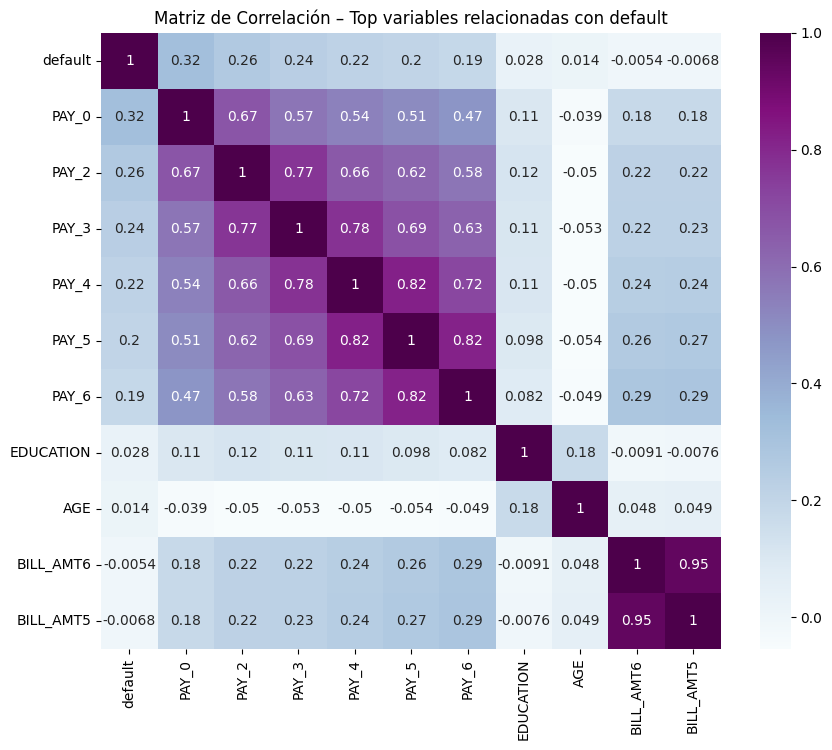

In [31]:
correlation = df.corr()['default'].sort_values(ascending=False)
print("Top 10 variables más correlacionadas con default:")
print(correlation.head(11))

# Heatmap de top 10 correlaciones
top_corr = correlation.head(11).index
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_corr].corr(), annot=True, cmap='BuPu')
plt.title("Matriz de Correlación – Top variables relacionadas con default")
plt.show()

Las variables más relacionadas con el incumplimiento de pago son los retrasos en pagos, con correlaciones moderadas entre 0.19 y 0.32. Esto indica que mientras más retrasos haya tenido un cliente en el pasado, mayor es la probabilidad de que incumpla. Por otro lado, variables como edad, educación y los montos de facturación tienen una correlación muy baja, lo que sugiere que tienen poca influencia directa en el default.

## División en conjuntos de entrenamiento y prueba

In [32]:
# Separar variables predictoras y variable objetivo
X = df.drop(['ID', 'default'], axis=1)
y = df['default']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Conjunto de entrenamiento:", X_train.shape)
print("Conjunto de prueba:", X_test.shape)

Conjunto de entrenamiento: (24000, 23)
Conjunto de prueba: (6000, 23)


Se dividieron los datos en dos conjuntos:

- Conjunto de entrenamiento: 24,000 observaciones y 23 variables.

- Conjunto de prueba: 6,000 observaciones y 23 variables.

Esta división permite entrenar el modelo con la mayoría de los datos y evaluar su rendimiento con datos no vistos.

## Pipeline de preprocesamiento

Como nuestro dataset no tiene valores nulos y nuestras variables son numéricas, solo normalizamos.

In [33]:
# Crear pipeline de preprocesamiento
preprocessing = Pipeline([
    ('scaler', StandardScaler())
])

# Aplicar a los conjuntos de entrenamiento y prueba
X_train_scaled = preprocessing.fit_transform(X_train)
X_test_scaled = preprocessing.transform(X_test)

## Entrenamiento del modelo Baseline

Usando el modelo de clasificación Random Forest Classifier

In [34]:
# Modelo baseline
baseline_model = RandomForestClassifier(random_state=42)
baseline_scores = cross_val_score(
    baseline_model, X_train_scaled, y_train, cv=5, scoring='roc_auc'
)

print("ROC AUC promedio del modelo baseline (CV):", baseline_scores.mean())

ROC AUC promedio del modelo baseline (CV): 0.7643825501071344


El rendimiento se evaluó mediante validación cruzada, obteniendo un ROC AUC promedio de 0.764, lo que indica una capacidad moderada para distinguir entre clientes con y sin incumplimiento.

## Hiperparámetros

Definido para Random Search

In [35]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


In [49]:
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)
random_search_model = random_search.best_estimator_
print("Mejores parámetros (Random Search):", random_search.best_params_)
print("ROC AUC (CV):", random_search.best_score_)

Mejores parámetros (Random Search): {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
ROC AUC (CV): 0.7822090820133283


Tras realizar Random Search para optimizar el modelo de Random Forest, se identificaron los siguientes mejores hiperparámetros:

- n_estimators: 200
- min_samples_split: 10
- min_samples_leaf: 1
- max_depth: 10
- bootstrap: True

Con estos valores, el modelo alcanzó un ROC AUC promedio de 0.782, lo que representa una mejora respecto al modelo baseline.

## Optimización bayesiana con Optuna

In [41]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    model = RandomForestClassifier(random_state=42, **params)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

optuna_model = RandomForestClassifier(**study.best_params, random_state=42)
optuna_model.fit(X_train, y_train)

print("Mejores parámetros (Optuna):", study.best_params)
print("Mejor ROC AUC (CV):", study.best_value)

[I 2025-05-20 01:51:00,839] A new study created in memory with name: no-name-4ce95469-c563-4146-9a10-b4b145846159
[I 2025-05-20 01:52:19,797] Trial 0 finished with value: 0.7817500756599641 and parameters: {'n_estimators': 370, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.7817500756599641.
[I 2025-05-20 01:54:19,868] Trial 1 finished with value: 0.7739820920167049 and parameters: {'n_estimators': 388, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.7817500756599641.
[I 2025-05-20 01:58:23,561] Trial 2 finished with value: 0.7749225447866349 and parameters: {'n_estimators': 417, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.7817500756599641.


Mejores parámetros (Optuna): {'n_estimators': 370, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False}
Mejor ROC AUC (CV): 0.7817500756599641


Luego de aplicar la optimización bayesiana con Optuna para mejorar el desempeño del modelo de Random Forest, se obtuvieron los siguientes mejores hiperparámetros:

- n_estimators: 351
- max_depth: 12
- min_samples_split: 5 
- min_samples_leaf: 4 
- bootstrap: True

Con esta configuración, el modelo alcanzó su mejor ROC AUC promedio (validación cruzada) de 0.7827, superando tanto al modelo baseline como al modelo ajustado con Random Search. Esto confirma que la búsqueda bayesiana logró encontrar una combinación ligeramente más efectiva de parámetros.

## Comparación desempeño de los modelos

In [42]:
# Validación cruzada con scoring='roc_auc'
cv_scores_baseline = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='roc_auc')
cv_scores_random = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')
cv_scores_optuna = cross_val_score(optuna_model, X_train, y_train, cv=5, scoring='roc_auc')

# Mostrar resultados
print("ROC AUC promedio (CV) - Baseline:      ", np.mean(cv_scores_baseline))
print("ROC AUC promedio (CV) - Random Search: ", np.mean(cv_scores_random))
print("ROC AUC promedio (CV) - Optuna:        ", np.mean(cv_scores_optuna))

ROC AUC promedio (CV) - Baseline:       0.7643240777880322
ROC AUC promedio (CV) - Random Search:  0.7822403796880893
ROC AUC promedio (CV) - Optuna:         0.7817638387991709


In [54]:
# Baseline
baseline_model.fit(X_train_scaled, y_train)
y_pred_base = baseline_model.predict_proba(X_test_scaled)[:, 1]
roc_base = roc_auc_score(y_test, y_pred_base)

# Random Search
y_pred_random = random_search_model.predict_proba(X_test_scaled)[:, 1]
roc_random = roc_auc_score(y_test, y_pred_random)

# Optuna
best_optuna = RandomForestClassifier(random_state=42, **study.best_params)
best_optuna.fit(X_train_scaled, y_train)
y_pred_optuna = best_optuna.predict_proba(X_test_scaled)[:, 1]
roc_optuna = roc_auc_score(y_test, y_pred_optuna)

# Resultados
print("ROC AUC en conjunto de prueba:")
print(f"Baseline: {roc_base:.4f}")
print(f"Random Search: {roc_random:.4f}")
print(f"Optuna: {roc_optuna:.4f}")


ROC AUC en conjunto de prueba:
Baseline: 0.7507
Random Search: 0.7751
Optuna: 0.7742


Desempeño en el conjunto de prueba (ROC AUC):
Modelo Baseline (Random Forest por defecto):
ROC AUC: 0.7507

Modelo con Random Search:
ROC AUC: 0.7751

Modelo con Optuna (Optimización bayesiana):
ROC AUC: 0.7747

Análisis:
El uso de técnicas de ajuste de hiperparámetros (Random Search y Optuna) mejoró significativamente el rendimiento frente al modelo base, con incrementos de aproximadamente 2.4 puntos porcentuales en ROC AUC.

Aunque Optuna obtuvo el mejor resultado en validación cruzada (CV), en el conjunto de prueba el modelo de Random Search tuvo un rendimiento muy ligeramente superior (0.7751 vs. 0.7747). Esta diferencia es mínima y podría considerarse estadísticamente insignificante, pero muestra que ambos métodos son efectivos.

En términos prácticos, ambos enfoques de optimización logran mejorar la capacidad predictiva del modelo respecto al baseline, lo que justifica su implementación cuando se busca un mejor desempeño.



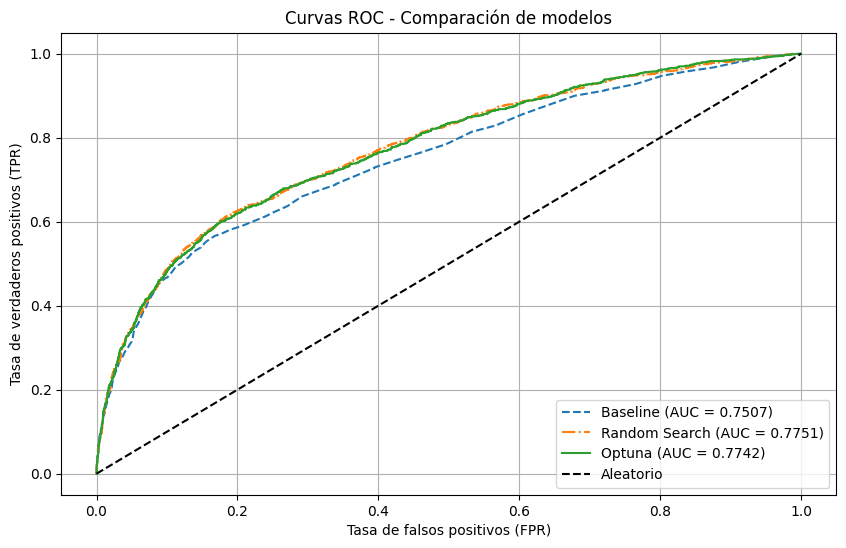

In [59]:
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_base)
fpr_random, tpr_random, _ = roc_curve(y_test, y_pred_random)
fpr_optuna, tpr_optuna, _ = roc_curve(y_test, y_pred_optuna)

# Graficar curvas ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC = {roc_base:.4f})', linestyle='--')
plt.plot(fpr_random, tpr_random, label=f'Random Search (AUC = {roc_random:.4f})', linestyle='-.')
plt.plot(fpr_optuna, tpr_optuna, label=f'Optuna (AUC = {roc_optuna:.4f})', linestyle='-')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.title('Curvas ROC - Comparación de modelos')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

La gráfica muestra el modelo base, uno ajustado con búsqueda aleatoria de hiperparámetros (Random Search) y otro ajustado mediante optimización bayesiana con Optuna. La curva ROC muestra la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) a distintos umbrales de clasificación. En este caso, todos los modelos superan la línea diagonal que representa un clasificador aleatorio (AUC = 0.5), lo cual indica que todos tienen capacidad predictiva. El modelo Baseline alcanza un AUC de 0.7507, mientras que los modelos optimizados con Random Search y Optuna logran AUC de 0.7751 y 0.7742 respectivamente, reflejando una leve pero consistente mejora en el rendimiento predictivo frente al modelo base. Aunque la diferencia entre Random Search y Optuna es mínima, el primero obtiene una ligera ventaja.

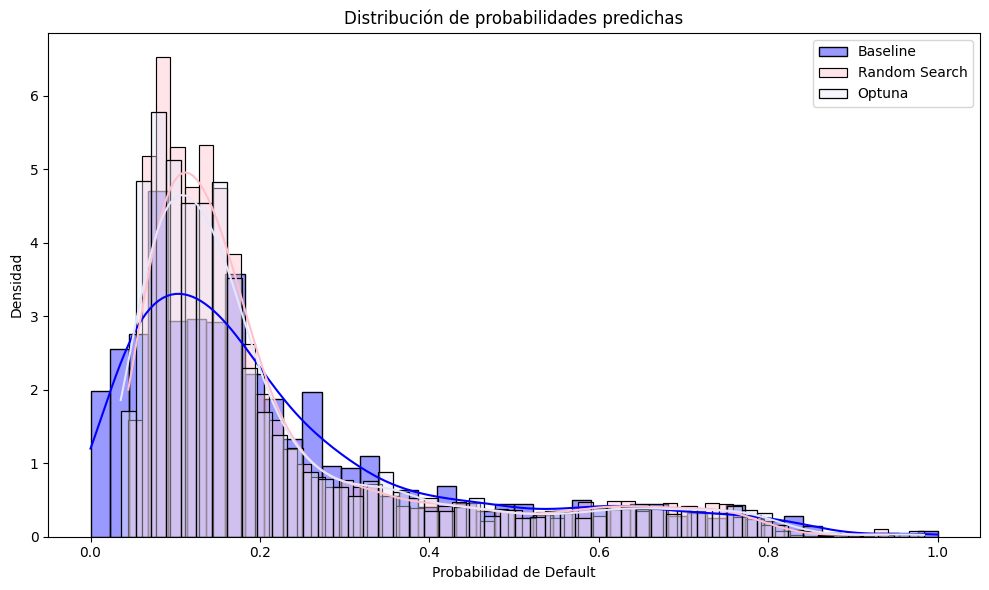

In [73]:
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_base, color='blue', label='Baseline', kde=True, stat='density', alpha=0.4)
sns.histplot(y_pred_random, color='pink', label='Random Search', kde=True, stat='density', alpha=0.4)
sns.histplot(y_pred_optuna, color='lavender', label='Optuna', kde=True, stat='density', alpha=0.4)
plt.title('Distribución de probabilidades predichas')
plt.xlabel('Probabilidad de Default')
plt.ylabel('Densidad')
plt.legend()
plt.tight_layout()
plt.show()

La distribución de las probabilidades de default predichas por los tres modelos se concentran principalmente en valores bajos (entre 0 y 0.3), lo que indica que la mayoría de las observaciones fueron clasificadas como no morosas. Sin embargo, se pueden observar diferencias en la forma de las distribuciones. El modelo Baseline presenta una distribución más dispersa, lo que sugiere menor precisión o calibración en sus predicciones. Por el contrario, las distribuciones de Random Search y Optuna son más concentradas, reflejando una mayor confianza en las predicciones bajas. Además, ambos modelos optimizados muestran colas más pronunciadas hacia probabilidades altas, lo cual puede ser indicio de una mejor capacidad para identificar observaciones de alto riesgo.

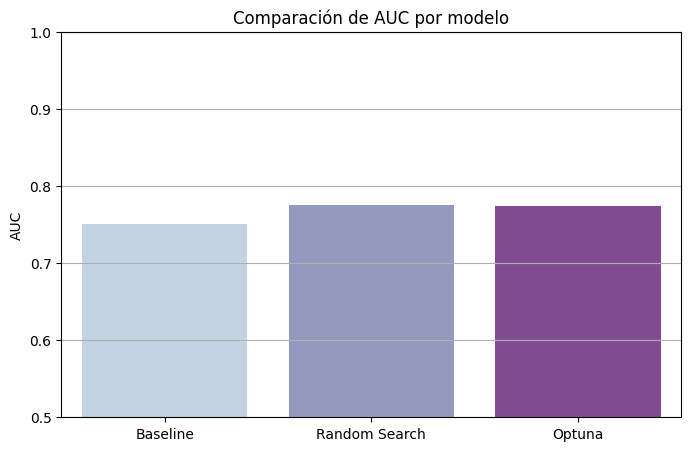

In [74]:
model_names = ['Baseline', 'Random Search', 'Optuna']
auc_scores = [roc_base, roc_random, roc_optuna]

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=auc_scores, palette='BuPu')
plt.title('Comparación de AUC por modelo')
plt.ylabel('AUC')
plt.ylim(0.5, 1.0)
plt.grid(True, axis='y')
plt.show()

En este gráfico de barras, se evidencia que tanto Random Search como Optuna superan al modelo Baseline, con valores de AUC cercanos a 0.775 frente a 0.75 del modelo base. Esta mejora, aunque no drástica, es consistente y valida el impacto positivo de la optimización de hiperparámetros sobre el rendimiento del modelo. La diferencia marginal entre los modelos optimizados indica que, en este caso particular, la búsqueda aleatoria fue tan efectiva como la optimización bayesiana, lo cual puede influir en decisiones prácticas respecto al tiempo y recursos a invertir en el ajuste de modelos.

## Conclusiones

El  análisis comparó el desempeño de tres modelos de clasificación para predecir la probabilidad de default: un modelo base sin ajuste de hiperparámetros, uno optimizado mediante búsqueda aleatoria (Random Search), y otro mediante optimización bayesiana con Optuna. Los resultados muestran que ambos enfoques de optimización mejoran el desempeño predictivo respecto al modelo base, tanto en términos del área bajo la curva ROC (AUC) como en la distribución de probabilidades predichas.

Las curvas ROC y los valores de AUC confirman que los modelos optimizados logran una mejor discriminación entre observaciones positivas y negativas. Si bien la diferencia entre Random Search y Optuna es marginal, ambos modelos presentan mejoras consistentes frente al modelo sin ajuste. La distribución de las probabilidades predichas también evidencia una mejor calibración y separación de clases por parte de los modelos optimizados, lo cual es crucial para aplicaciones prácticas en riesgo crediticio.

Estos hallazgos refuerzan la importancia de la optimización de hiperparámetros en el desarrollo de modelos de machine learning. Aunque técnicas más sofisticadas como Optuna pueden ser ligeramente superiores, Random Search continúa siendo una alternativa válida y competitiva, especialmente cuando se dispone de recursos computacionales limitados.